In [2]:
import math
import time
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import numpy as np
from numpy import linalg
import scipy.io as sio
from sklearn.cluster import KMeans
from sklearn import metrics
from matplotlib.ticker import FormatStrFormatter
import matplotlib.font_manager as font_manager


%matplotlib notebook

Created May 13, 2021

Analysis of Rh=5.3%Sr2IrO4 grid


In [3]:
#Upload data, preprocessed in Matlab. 

def MATLAB_file_to_array(fileName, variableName):
    #fileName should be string of the full path and fileName
    #variableName should be string of workspace variable name as it was in MATLAB
    
    matrix = sio.loadmat(fileName)
    array = matrix[variableName]
    print("Shape of array: ",np.shape(array))
    
    return array

data_18_77K = MATLAB_file_to_array('/Users/vanessa/Desktop/UBC/Lab/Iridates_Project/Grid006_Rh18_77K.mat', 'my_variable')
data_18_4K = MATLAB_file_to_array('/Users/vanessa/Desktop/UBC/Lab/Iridates_Project/Grid006_Rh18_4K.mat', 'dIdVN')
data_5 = MATLAB_file_to_array('/Users/vanessa/Desktop/UBC/Lab/Iridates_Project/raw_data.mat','raw_data')
data_line = MATLAB_file_to_array('/Users/vanessa/Desktop/UBC/Lab/Iridates_Project/Seokhwan_Figure_Files/Line_dIdVs/dIdVN.mat','dIdVN')


Shape of array:  (60, 60, 201)
Shape of array:  (275, 275, 81)
Shape of array:  (275, 275, 81)
Shape of array:  (256, 801)


In [7]:
def my_kmeans(file, n_clusters):
    #Data needs to be in shape (n_samples, n_features), ie: (75625, 81)
    data = np.reshape(file, (np.shape(file)[0]*np.shape(file)[1], np.shape(file)[2]))
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=100, max_iter=100, random_state=0).fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    #https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index
    #Calinski-Harabasz Index for quality of fit evaluation. A high value signifies a good fit. Equals BCSS / WCSS
    score = metrics.calinski_harabasz_score(data, labels)
    print('k-means complete. BCSS / WCSS = {:0.6e}'.format(score))
     
    return labels, centroids, score


def kmeans_Plot(grid, minV, maxV, labels, centroids):
    #Inputs:
    #grid = 3 dimensional data array, minV = starting voltage, maxV = final voltage, 
    #labels = labels output from kmeans, centroids = centroids output from kmeans
    
    energy = np.linspace(minV, maxV, num=np.shape(grid)[2]) #evenly spaced values between minV and maxV
    img_labels = np.reshape(labels, (np.shape(grid)[0],np.shape(grid)[1])) #Reformating labels for map layout
    
    #Plotting
    #Note on colour: '#003C86' is navy for P1
    #                '#EF0096' is magenta for M
    #                'k' is black for DEFFECT
    #                '#00DCB5'is teal for P2
    
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.subplots_adjust(hspace=0.3)
    
    ax1.plot(energy,centroids[0],label="Centroid 1", marker='',linestyle='-', lw=2, color='#EF0096')
    ax1.plot(energy,centroids[1],label="Centroid 2", marker='',linestyle='-', lw=2, color='k')
    ax1.plot(energy,centroids[2],label="Centroid 3", marker='',linestyle='-', lw=2, color='#00DCB5')
    ax1.plot(energy,centroids[3],label="Centroid 4", marker='',linestyle='-', lw=2, color='#003C86')

    ax1.set_ylabel("DOS")
    ax1.set_xlabel("Bias (eV)")
    ax1.set_title("Spectra of k-means centroids")
    ax1.legend()
    ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
    ax1.set_ylim(0.0, 1.50E-11)
    
    cmap = colors.ListedColormap(['#EF0096','k','#00DCB5','#003C86'])
    ax2.imshow(img_labels, cmap=cmap)
    ax2.set_title("Map of cluster assignments")
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    plt.show()

k-means complete. BCSS / WCSS = 2.467402e+04


<IPython.core.display.Javascript object>


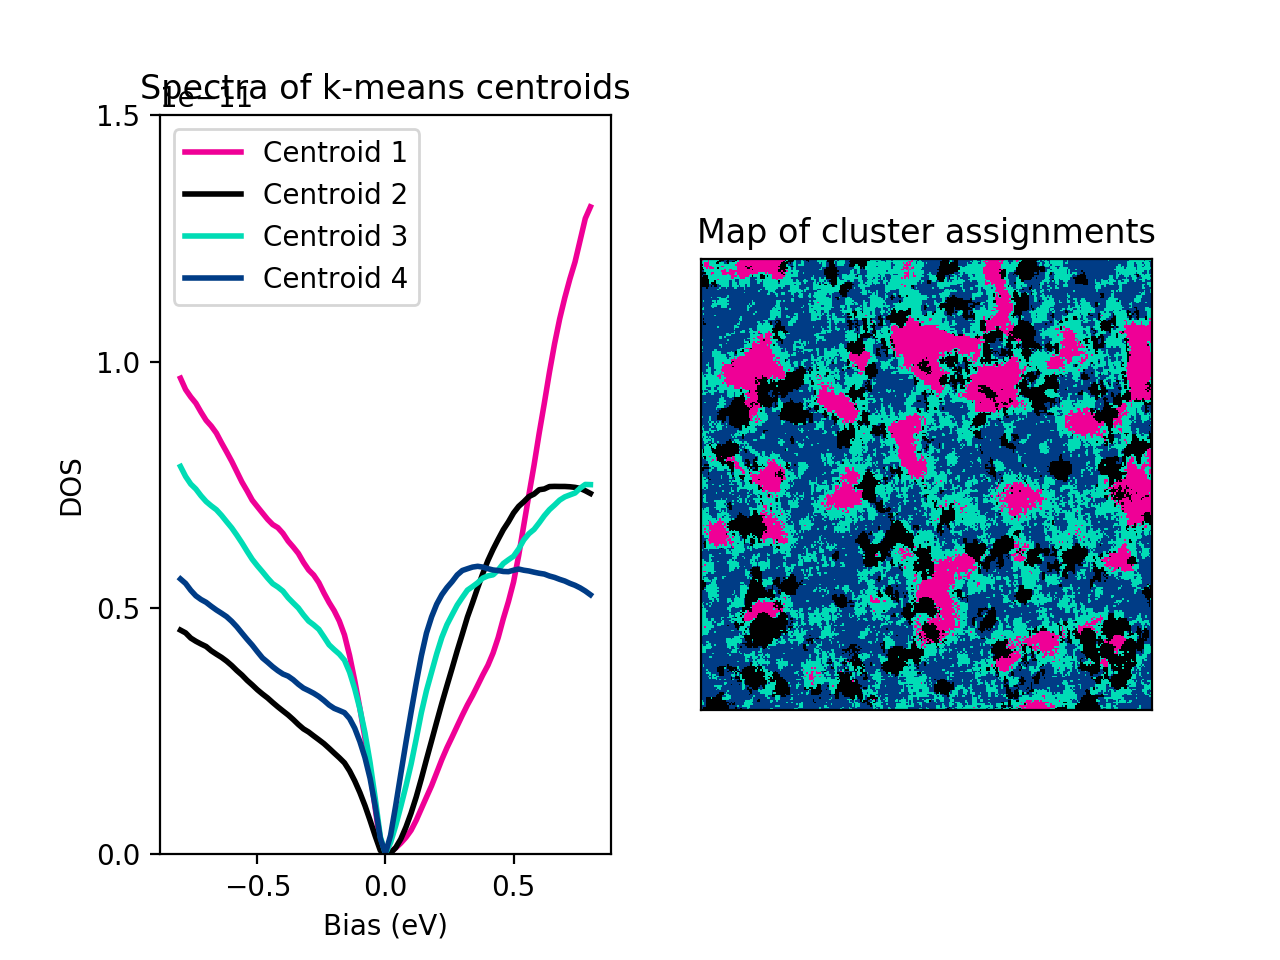

In [8]:


labels, centroids, score = my_kmeans(data_5, 4)
#labels, centroids, score = my_kmeans(data_18_4K, 2)
#labels, centroids, score = my_kmeans(data_18_77K, 2)
kmeans_Plot(data_5,-0.8,0.8,labels,centroids)
#kmeans_Plus = labels

In [9]:
#function to pick out spectra of interest
def spectra_of_interest(data, labels, cluster):
    # data : output from MATLAB_file_to_array function, 3D grid map array
    # labels : output from import_labels function, 2D array results from kMeans
    # cluster : the cluster of interest, using number from labels array (ie: for 4 clusters, either 0, 1, 2, or 3)
    
    #First, make 2D version of data array, ie:(275,275,81)-->(75625, 81)
    data_2D = np.reshape(data, (np.shape(data)[0]*np.shape(data)[1], np.shape(data)[2]))
    
    #Second, make 1D version of labels array, ie:(275,275-->(75625)
    labels_1D = np.reshape(labels, np.shape(labels)[0]*np.shape(labels)[1])

    #Next, pick out the spectra that fall under the specified cluster and add them to a list
    spectra = []
    for i in range(len(labels_1D)):
        if labels_1D[i]==cluster: 
            spectra.append(data_2D[i])
        
    return spectra


#divide up the spectra into its clusters:
M_spectra = spectra_of_interest(data_5, labels, 0)#magenta on saved plot
P1_spectra = spectra_of_interest(data_5, labels, 3)#dark blue on saved plot
D_spectra = spectra_of_interest(data_5, labels, 1)#black on saved plot
P2_spectra = spectra_of_interest(data_5, labels, 2)#teal on saved plot

print("There are ",np.shape(M_spectra)[0]," Mott spectra (magenta).")
print("There are ",np.shape(D_spectra)[0]," defect spectra (black).")
print("There are ",np.shape(P1_spectra)[0]," P1 spectra (dark blue).")
print("There are ",np.shape(P2_spectra)[0]," P2 spectra (teal).")

IndexError: tuple index out of range

<IPython.core.display.Javascript object>


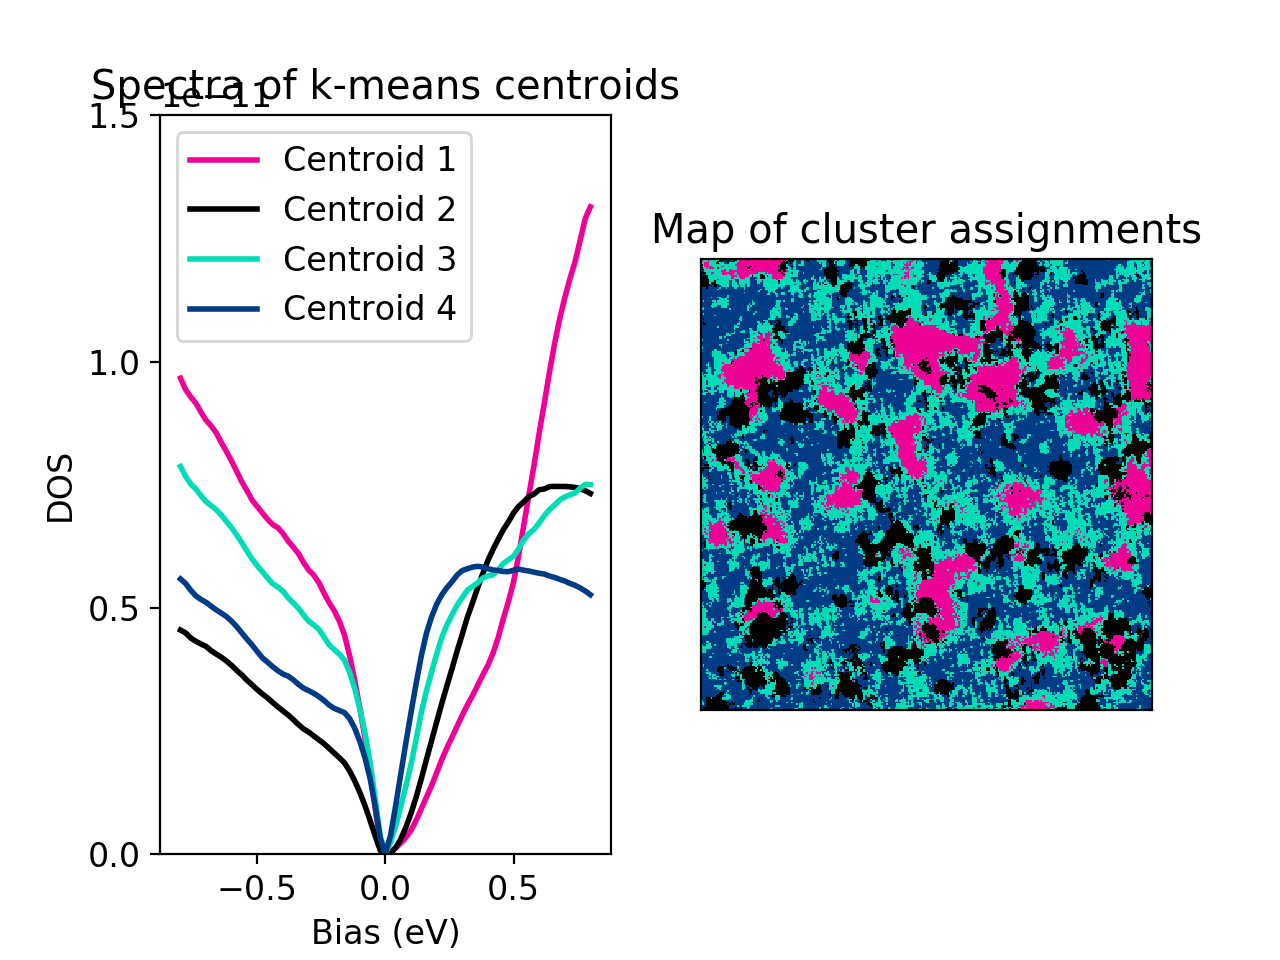

In [25]:
img_labels = np.reshape(labels, (np.shape(data_5)[0],np.shape(data_5)[1])) #Reformating labels for map layout
energy = np.linspace(-0.8, 0.8, num=np.shape(data_5)[2])

#Plotting
#Note on colour: '#003C86' is navy for P1
#                '#EF0096' is magenta for M
#                'k' is black for DEFFECT
#                '#00DCB5'is teal for P2
    
fig,(ax1,ax2) = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.3)
    
ax1.plot(energy,centroids[0],label="Centroid 1", marker='',linestyle='-', lw=2, color='#EF0096')
ax1.plot(energy,centroids[1],label="Centroid 2", marker='',linestyle='-', lw=2, color='k')
ax1.plot(energy,centroids[2],label="Centroid 3", marker='',linestyle='-', lw=2, color='#00DCB5')
ax1.plot(energy,centroids[3],label="Centroid 4", marker='',linestyle='-', lw=2, color='#003C86')

ax1.set_ylabel("DOS")
ax1.set_xlabel("Bias (eV)")
ax1.set_title("Spectra of k-means centroids")
ax1.legend()
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
ax1.set_ylim(0.0, 1.50E-11)
    
cmap = colors.ListedColormap(['#EF0096','k','#00DCB5','#003C86'])
ax2.imshow(img_labels, cmap=cmap)
ax2.set_title("Map of cluster assignments")
ax2.set_xticks([])
ax2.set_yticks([])
    
plt.show()

#plt.savefig("4cluster_5%_label_map_only_nw.png",bbox_inches='tight')

In [11]:
#save to cluster assignments to file
img_labels = np.reshape(labels, (np.shape(data_5)[0],np.shape(data_5)[1]))
np.savetxt("Rh5_4K_4cluster_labels.csv", img_labels, delimiter=',')

np.savetxt("Rh5_4K_4cluster_centroids.csv",centroids,delimiter=',')

(75625, 81)


<IPython.core.display.Javascript object>


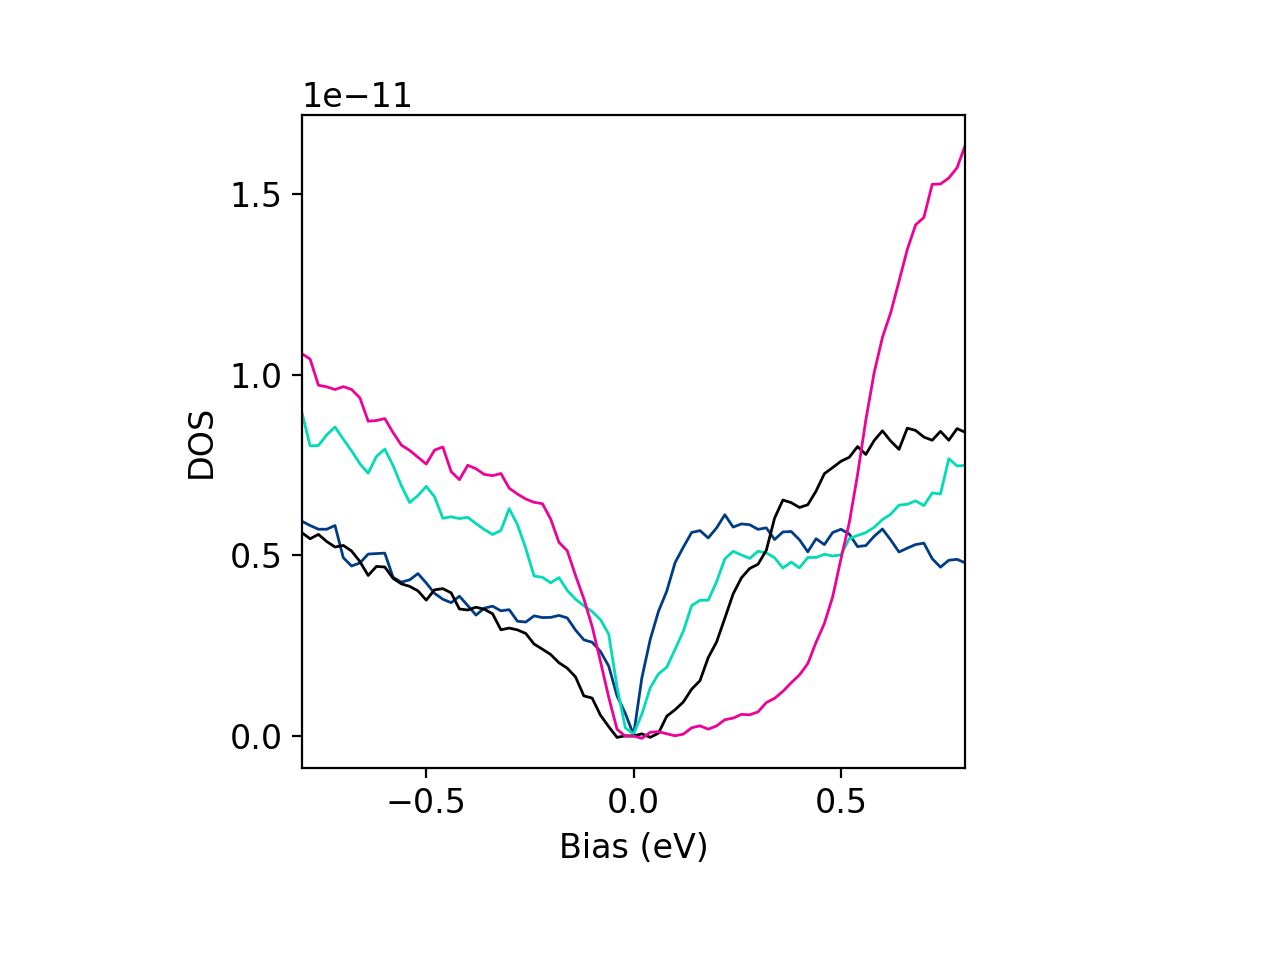

In [27]:
data_2 = np.reshape(data_5, (np.shape(data_5)[0]*np.shape(data_5)[1], np.shape(data_5)[2]))
print(np.shape(data_2))

#Want to choose and average over some example spectra for dIdVN(:,:,:,2)
P1 = [(275*5)+240-2, (275*5)+240-1, (275*5)+240, (275*5)+240+1, (275*5)+240+2] # (240, 5) and surrounding pixels
P2 = [31024, 31025, 31026, 31027, 31028] # (225,112) and surrounding pixels
D = [36829, 36830, 36831, 36832, 36833] # (255,133) and surrounding pixels
M = [(275*55)+130-2, (275*55)+130-1, (275*55)+130, (275*55)+130+1, (275*55)+130+2] # (130, 55) and surrounding pixels


P1_sample_spectra = [np.mean([data_2[P1[0],i], data_2[P1[1],i], data_2[P1[2],i]]) for i in range(len(data_2[0]))]
P2_sample_spectra = [np.mean([data_2[P2[0],i], data_2[P2[1],i], data_2[P2[2],i]]) for i in range(len(data_2[0]))]
D_sample_spectra = [np.mean([data_2[D[0],i], data_2[D[1],i], data_2[D[2],i]]) for i in range(len(data_2[0]))]
M_sample_spectra = [np.mean([data_2[M[0],i], data_2[M[1],i], data_2[M[2],i]]) for i in range(len(data_2[0]))]


energy = np.linspace(-0.8, 0.8, num=81) #evenly spaced values between -0.8 eV and 0.8 eV
img_labels = np.reshape(labels, (275,275)) #Reformating labels for map layout

#Plotting
plt.rcParams.update({'font.size': 12})
fig,(ax1) = plt.subplots()
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(left=0.09)

fig.subplots_adjust(bottom=0.2)

ax1.plot(energy,P1_sample_spectra, marker='',linestyle='-', lw=1, color='#003C86')
ax1.plot(energy,P2_sample_spectra, marker='',linestyle='-', lw=1, color='#00DCB5')
ax1.plot(energy,D_sample_spectra, marker='',linestyle='-', lw=1, color='k')
ax1.plot(energy,M_sample_spectra, marker='',linestyle='-', lw=1, color='#EF0096')

ax1.set_ylabel("DOS", fontsize=12)
ax1.set_xlabel("Bias (eV)", fontsize=12)
#ax1.set_title("Representative spectra of the distinct states", pad=20, fontsize=13)
ax1.set_xlim([-0.8,0.8])
ax1.set_aspect(87010000111)
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
#ax1.xaxis.set_ticks(np.arange(-0.8, 0.8, 0.5))

plt.show()
#plt.savefig('sample_spectra.png')

/Users/vanessa/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=100.
  self._check_params(X)


k-means complete. BCSS / WCSS = 2.467396e+04


<IPython.core.display.Javascript object>


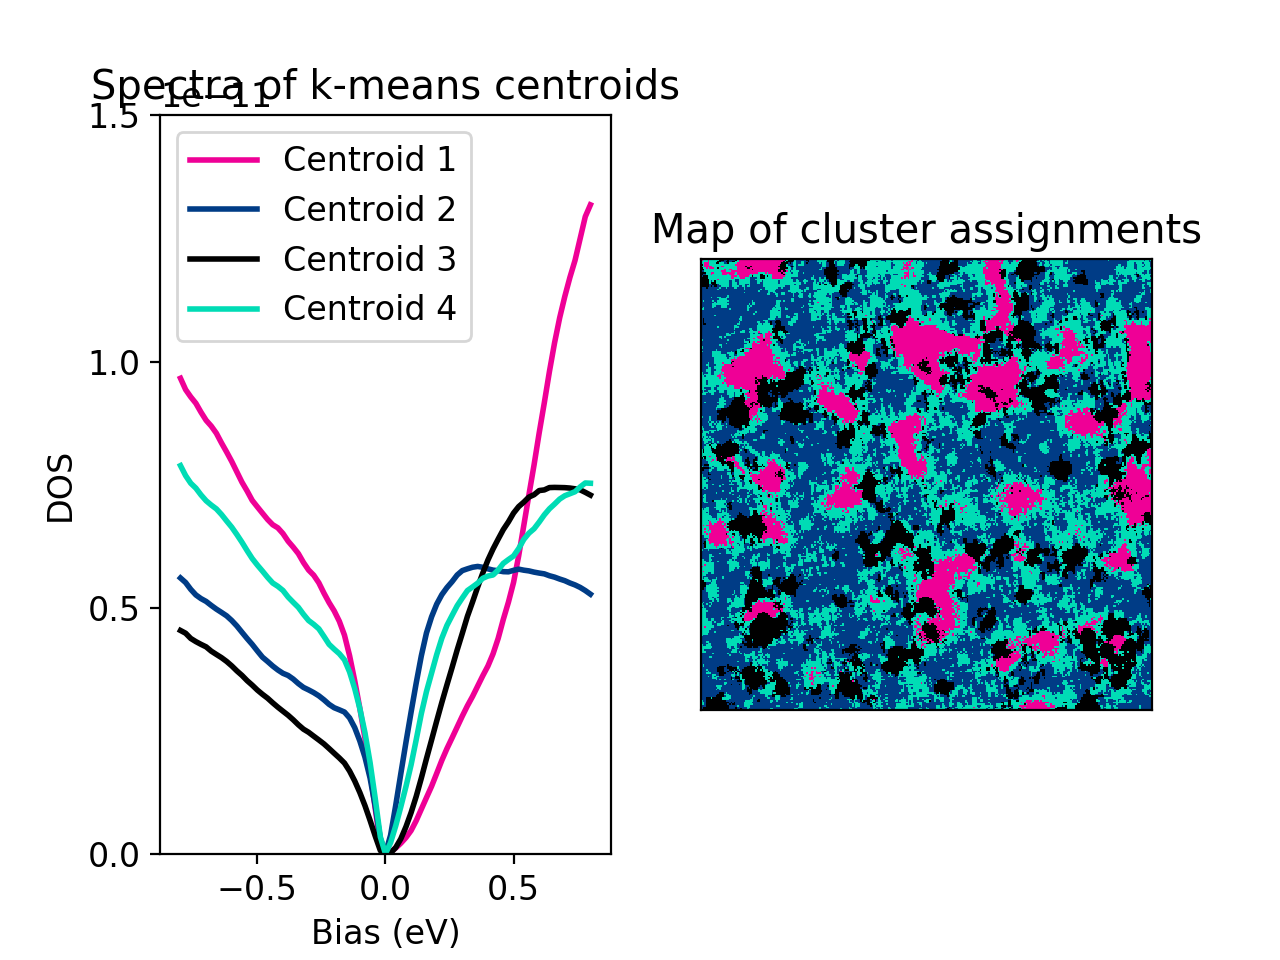

In [28]:
#Trying to input example spectra as initial centroids:

def my_kmeans_given_centroids(file, n_clusters, initial_centroids):
    #Data needs to be in shape (n_samples, n_features), ie: (75625, 81)
    data = np.reshape(file, (np.shape(file)[0]*np.shape(file)[1], np.shape(file)[2]))
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    kmeans = KMeans(n_clusters=n_clusters, init=initial_centroids, n_init=100, max_iter=100, random_state=0).fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    #https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index
    #Calinski-Harabasz Index for quality of fit evaluation. A high value signifies a good fit. Equals BCSS / WCSS
    score = metrics.calinski_harabasz_score(data, labels)
    print('k-means complete. BCSS / WCSS = {:0.6e}'.format(score))
    
    return labels, centroids, score

initial_centroids = np.asarray([M_sample_spectra, P1_sample_spectra, D_sample_spectra, P2_sample_spectra])
labels, centroids, score = my_kmeans_given_centroids(data_5, 4, initial_centroids)

def kmeans_Plot(grid, minV, maxV, labels, centroids):
    #Inputs:
    #grid = 3 dimensional data array, minV = starting voltage, maxV = final voltage, 
    #labels = labels output from kmeans, centroids = centroids output from kmeans
    
    energy = np.linspace(minV, maxV, num=np.shape(grid)[2]) #evenly spaced values between minV and maxV
    img_labels = np.reshape(labels, (np.shape(grid)[0],np.shape(grid)[1])) #Reformating labels for map layout
    
    #Plotting
    #Note on colour: '#003C86' is navy for P1
    #                '#EF0096' is magenta for M
    #                'k' is black for DEFFECT
    #                '#00DCB5'is teal for P2
    
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.subplots_adjust(hspace=0.3)
    
    ax1.plot(energy,centroids[0],label="Centroid 1", marker='',linestyle='-', lw=2, color='#EF0096')
    ax1.plot(energy,centroids[1],label="Centroid 2", marker='',linestyle='-', lw=2, color='#003C86')
    ax1.plot(energy,centroids[2],label="Centroid 3", marker='',linestyle='-', lw=2, color='k')
    ax1.plot(energy,centroids[3],label="Centroid 4", marker='',linestyle='-', lw=2, color='#00DCB5')

    ax1.set_ylabel("DOS")
    ax1.set_xlabel("Bias (eV)")
    ax1.set_title("Spectra of k-means centroids")
    ax1.legend()
    ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
    ax1.set_ylim(0.0, 1.50E-11)
    
    cmap = colors.ListedColormap(['#EF0096','#003C86','k','#00DCB5'])
    ax2.imshow(img_labels, cmap=cmap)
    ax2.set_title("Map of cluster assignments")
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    plt.show()
    
kmeans_Plot(data_5,-0.8,0.8,labels,centroids)

initial_Centroids = labels

Percentage mismatch between solutions: 0.74%


<IPython.core.display.Javascript object>


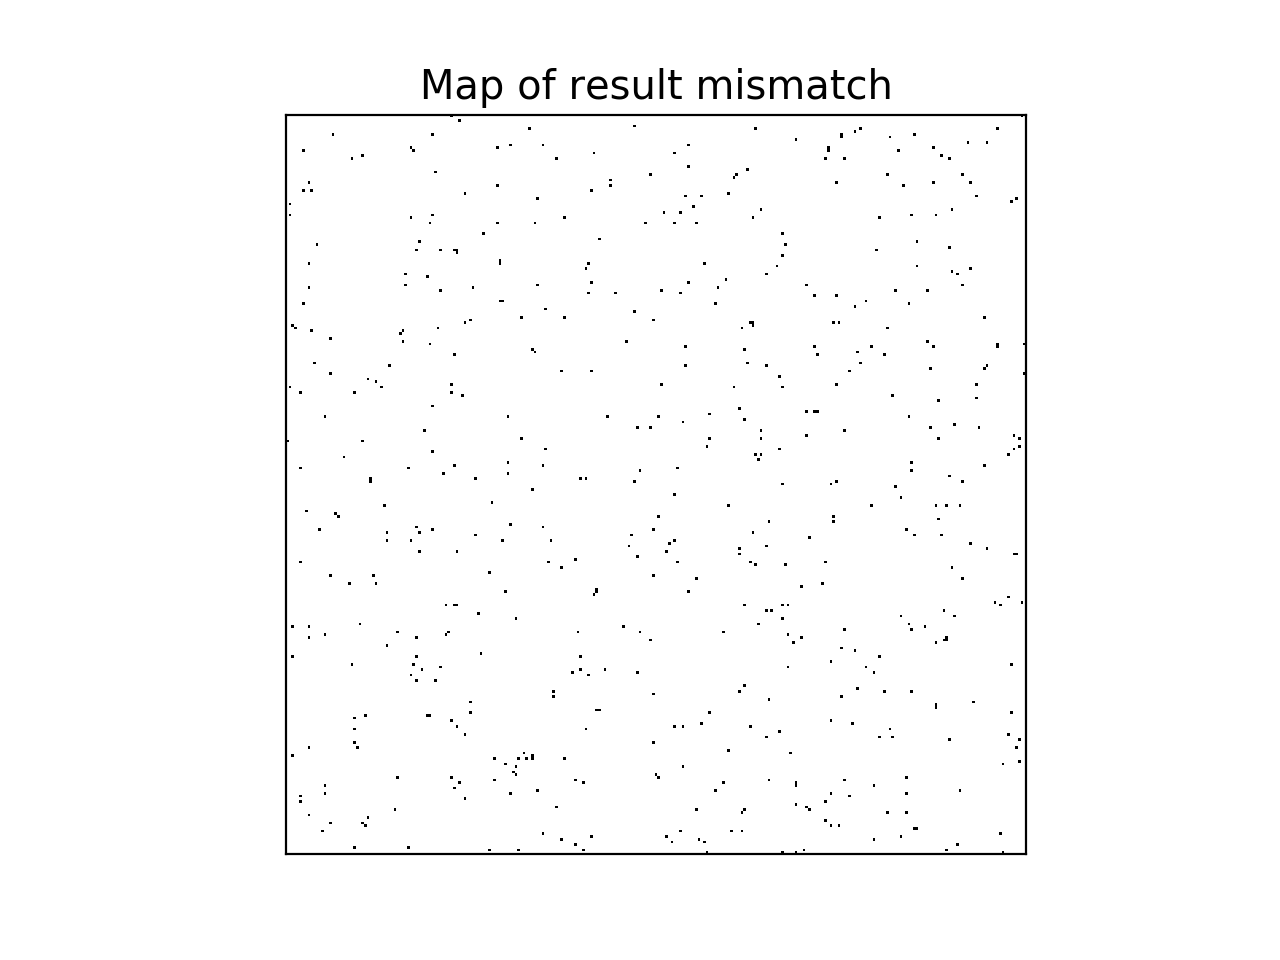

In [78]:
#Counting the differences between kmeans++ method and initialCentroids method

kmeans_Plus_labelled = ['M' if i==0 else i for i in kmeans_Plus]
kmeans_Plus_labelled = ['N' if i==3 else i for i in kmeans_Plus_labelled]
kmeans_Plus_labelled = ['T' if i==2 else i for i in kmeans_Plus_labelled]
kmeans_Plus_labelled = ['B' if i==1 else i for i in kmeans_Plus_labelled]

initial_Centroids_labelled = ['M' if i==0 else i for i in initial_Centroids]
initial_Centroids_labelled = ['N' if i==1 else i for i in initial_Centroids_labelled]
initial_Centroids_labelled = ['T' if i==3 else i for i in initial_Centroids_labelled]
initial_Centroids_labelled = ['B' if i==2 else i for i in initial_Centroids_labelled]

mismatch = np.asarray([kmeans_Plus_labelled[i]!=initial_Centroids_labelled[i] for i in range(np.shape(kmeans_Plus)[0])])
percentage = test.sum()/np.shape(kmeans_Plus)[0]
print("Percentage mismatch between solutions: {:0.2%}".format(percentage))


img_mismatch = np.reshape(mismatch, (np.shape(data_5)[0],np.shape(data_5)[1])) #Reformating labels for map layout

                          
fig, ax = plt.subplots()
cmap = colors.ListedColormap(['w','k'])
ax.imshow(img_mismatch, cmap=cmap)
ax.set_title("Map of result mismatch")
ax.set_xticks([])
ax.set_yticks([])
    
plt.show()

<IPython.core.display.Javascript object>


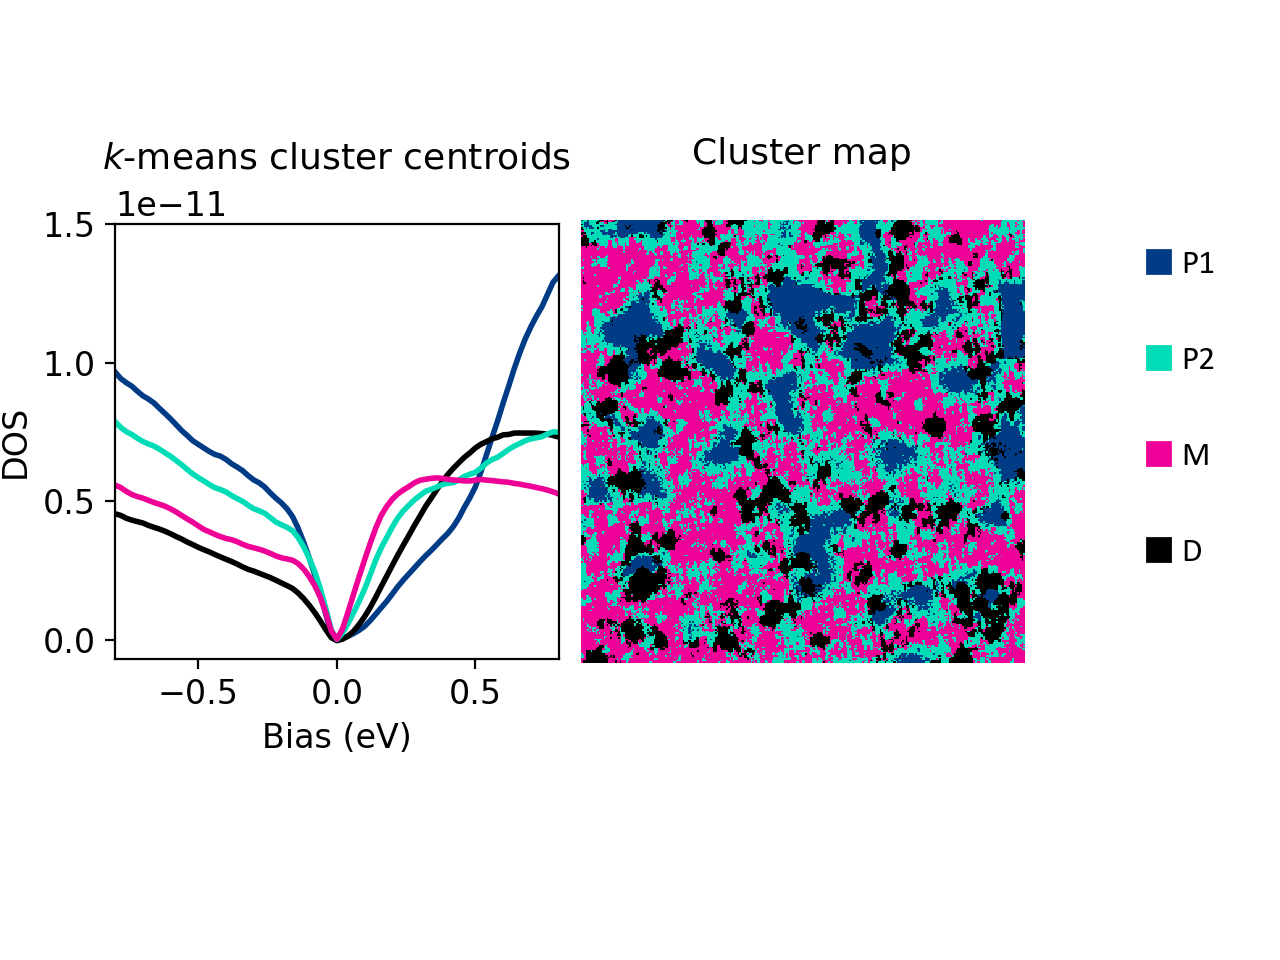

In [5]:
energy = np.linspace(-0.8, 0.8, num=81) #evenly spaced values between -0.8 eV and 0.8 eV
img_labels = np.reshape(labels, (275,275)) #Reformating labels for map layout

#Plotting
plt.rcParams.update({'font.size': 12})
fig,(ax1,ax2) = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(left=0.09)
fig.subplots_adjust(right=0.8)
fig.subplots_adjust(bottom=0.2)


ax1.plot(energy,centroids[0], marker='',linestyle='-', lw=2, color='#003C86')
ax1.plot(energy,centroids[1], marker='',linestyle='-', lw=2, color='k')
ax1.plot(energy,centroids[2], marker='',linestyle='-', lw=2, color='#00DCB5')
ax1.plot(energy,centroids[3], marker='',linestyle='-', lw=2, color='#EF0096')

ax1.set_ylabel("DOS", fontsize=12)
ax1.set_xlabel("Bias (eV)", fontsize=12)
ax1.set_title("$\it{k}$-means cluster centroids", pad=20, fontsize=13)
ax1.set_xlim([-0.8,0.8])
ax1.set_aspect(100000000000)
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))

clusterA = mpatches.Patch(color='#003C86', label='P1')
clusterB = mpatches.Patch(color='#00DCB5', label='P2')
clusterC = mpatches.Patch(color='k', label='D')
clusterD = mpatches.Patch(color='#EF0096', label='M')

font = font_manager.FontProperties(family='Calibri',size=12)
plt.legend(handles=[clusterA,clusterB,clusterD,clusterC], bbox_to_anchor=(1.5,1.0),
           frameon=False,handletextpad=0.35, labelspacing=2., handlelength=0.7, prop=font)


cmap = colors.ListedColormap(['#003C86', 'k', '#00DCB5','#EF0096'])
ax2.imshow(img_labels, cmap=cmap)
ax2.set_title("Cluster map", pad=20, fontsize=13)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)

plt.show()


In [9]:
centroid_1_indices  = np.reshape(np.where(labels==0), -1)
centroid_2_indices  = np.reshape(np.where(labels==1), -1)
centroid_3_indices  = np.reshape(np.where(labels==2), -1)
centroid_4_indices  = np.reshape(np.where(labels==3), -1)

#Choosing 100 random spectra from cluster to plot:
rng = np.random.default_rng()
index_choice_1 = rng.choice(centroid_1_indices,100, replace=False) #1
index_choice_2 = rng.choice(centroid_2_indices,100, replace=False) #2
index_choice_3 = rng.choice(centroid_3_indices,100, replace=False) #3
index_choice_4 = rng.choice(centroid_4_indices,100, replace=False) #4


flattened_data = np.reshape(data_77K, (np.shape(data_77K)[0]*np.shape(data_77K)[1], np.shape(data_77K)[2]))
print(np.shape(flattened_data))

NameError: name 'data_77K' is not defined

In [ ]:
#visualize spectral spread within a cluster
data = np.reshape(data_18_4K, (np.shape(data_18_4K)[0]*np.shape(data_18_4K)[1], np.shape(data_18_4K)[2]))
energy = np.linspace(-1, 1, num=np.shape(data_18_4K)[2]) #evenly spaced values between -0.8 eV and 0.8 eV

#Plotting
plt.rcParams.update({'font.size': 12})
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharex=True)
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(hspace=0.01)
fig.subplots_adjust(left=0.09)
fig.subplots_adjust(right=0.99)


#Subplot 1:
for i in range(100):
    ax1.plot(energy, flattened_data[index_choice_1[i]], marker='',ls='-', color='gray', alpha=0.3,lw=0.5)
    
#plot the centroid spectrum
ax1.plot(energy,centroids[0], marker='',linestyle='-', color='#EF0096', lw=2)
ax1.set_ylabel("DOS")
ax1.set_xlim([-1,1])
ax1.set_ylim([-0.1E-11,1.5E-11])
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
ax1.set_aspect(100000000000)


#Subplot 2:
for i in range(100):
    ax2.plot(energy, flattened_data[index_choice_3[i]], marker='',ls='-', color='gray', alpha=0.3, lw=0.5)
    
#plot the centroid spectrum
ax2.plot(energy,centroids[2], marker='',linestyle='-', color='k', lw=2)
ax2.set_xlim([-1,1])
ax2.set_ylim([-0.1E-11,1.5E-11])
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_aspect(100000000000)


#Subplot 3:
for i in range(100):
    ax3.plot(energy, flattened_data[index_choice_2[i]], marker='',ls='-', color='gray', alpha=0.3, lw=0.5)
    
#plot the centroid spectrum
ax3.plot(energy,centroids[1], marker='',linestyle='-', color='#003C86', lw=2)
ax3.set_xlim([-1,1])
ax3.set_ylim([-0.1E-11,1.5E-11])
ax3.yaxis.set_major_locator(plt.NullLocator())
ax3.set_aspect(100000000000)

#Subplot 4:
for i in range(100):
    ax4.plot(energy, flattened_data[index_choice_4[i]], marker='',ls='-', color='gray', alpha=0.3, lw=0.5)
    
#plot the centroid spectrum
ax4.plot(energy,centroids[3], marker='',linestyle='-', color='#00DCB5', lw=2)
ax4.set_xlim([-1,1])
ax4.set_ylim([-0.1E-11,1.5E-11])
ax4.yaxis.set_major_locator(plt.NullLocator())
ax4.set_aspect(100000000000)


# Set Title and x label
fig.text(0.54, 0.12, 'Bias (eV)', ha='center', va='center', fontsize=12)
#fig.text(0.54, 0.93, 'Sampling spectra within a cluster', ha='center', va='center', fontsize=13)
plt.show()

In [ ]:
#A finer look at maybe Mott regions
#Make plot of ALL spectra

data = np.reshape(data_18_77K, (np.shape(data_18_77K)[0]*np.shape(data_18_77K)[1], np.shape(data_18_77K)[2]))
energy = np.linspace(-1, 1, num=np.shape(data_18_77K)[2]) #evenly spaced values between -0.8 eV and 0.8 eV

#Plotting
plt.rcParams.update({'font.size': 12})
fig,(ax1) = plt.subplots(1,1)


#Subplot 2:
for i in range(len(centroid_3_indices)):
    ax1.plot(energy, flattened_data[centroid_3_indices[i]], marker='',ls='-', color='gray', alpha=0.3, lw=0.3)
    
#plot the centroid spectrum
ax1.plot(energy,centroids[2], marker='',linestyle='-', color='k', lw=1.5)
ax1.set_xlim([-1,1])
ax1.set_ylim([-0.1E-11,1.5E-11])
ax1.set_ylabel("DOS")

ax1.set_aspect(100000000000)

plt.show()


In [ ]:
energy = np.linspace(-1, 1, num=np.shape(data_5)[2])
print(energy[50])

In [ ]:
#Look at weird spectra that are maybe Mott
#Note: energy[75] = 0.25V, or energy[50] = 0.25V depending on which map you're looking at

data = np.reshape(data_5, (np.shape(data_5)[0]*np.shape(data_5)[1], np.shape(data_5)[2]))
energy = np.linspace(-1, 1, num=np.shape(data_5)[2]) #evenly spaced values between -0.8 eV and 0.8 eV

maybe_mott_indices = []
for i in range(np.shape(data)[0]):
    if data[i][50] < 0.09E-11:
        maybe_mott_indices.append(i)

maybe_mott_x = []
maybe_mott_y = []

for i in range(len(maybe_mott_indices)):
    
    y = np.floor(maybe_mott_indices[i]/np.shape(data_5)[0])
    x = maybe_mott_indices - np.shape(data_5)[0]*y
    
    maybe_mott_x.append(x)
    maybe_mott_y.append(y)

#Plotting
fig,(ax1,ax2) = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.3)

for i in range(len(maybe_mott_indices)):
    ax1.plot(energy, data[maybe_mott_indices[i]], marker='',ls='-', color='gray', alpha=0.3, lw=0.3)
ax1.set_xlim([-1,1])
ax1.set_ylim([-0.1E-11,1.5E-11])
ax1.set_ylabel("DOS")

ax2.plot(maybe_mott_x, maybe_mott_y, marker='.', markersize=1 ,linestyle='', color='k')
#ax2.set_aspect(1)
ax2.set_xlim(0,61)
ax2.set_ylim(0,61)
ax2.set_xticks([])
ax2.set_yticks([])


plt.show()
#plt.savefig('demo.png', transparent=True)

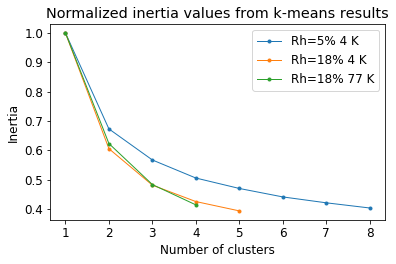

In [10]:
#Recorded Inertia Values from KMeans solutions

num_clusters_5 = [1,2,3,4,5,6,7,8]
Rh5_inertia = [1.7063640e-17, 1.1479805e-17, 9.6725288e-18, 8.6229765e-18, 8.0163849e-18, 7.5245543e-18,
                 7.1816453e-18, 6.8810109e-18]
Rh5_inertia_norm = [Rh5_inertia[i]/np.max(Rh5_inertia) for i in range(len(Rh5_inertia))]

num_clusters_18 = [1,2,3,4,5]
Rh18_inertia = [2.7274806e-17, 1.6511362e-17,1.3120892e-17,1.1596154e-17, 1.0728542e-17]
Rh18_inertia_norm = [Rh18_inertia[i]/np.max(Rh18_inertia) for i in range(len(Rh18_inertia))]

num_clusters_18_77 = [1,2,3,4]
Rh18_77_inertia = [2.2939538e-18, 1.4289480e-18, 1.1082470e-18, 9.4941680e-19]
Rh18_77_inertia_norm = [Rh18_77_inertia[i]/np.max(Rh18_77_inertia) for i in range(len(Rh18_77_inertia))]

#Inertia Plots
fig,(ax1) = plt.subplots()
plt.rcParams.update({'font.size': 12})
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(bottom=0.2)

ax1.plot(num_clusters_5, Rh5_inertia_norm, marker='.',linestyle='-', lw=1, label='Rh=5% 4 K')
ax1.plot(num_clusters_18, Rh18_inertia_norm, marker='.',linestyle='-', lw=1, label='Rh=18% 4 K')
ax1.plot(num_clusters_18_77, Rh18_77_inertia_norm, marker='.',linestyle='-', lw=1, label='Rh=18% 77 K')


ax1.set_ylabel("Inertia")
ax1.set_xlabel("Number of clusters")
ax1.set_title('Normalized inertia values from k-means results')
ax1.legend()


plt.show()

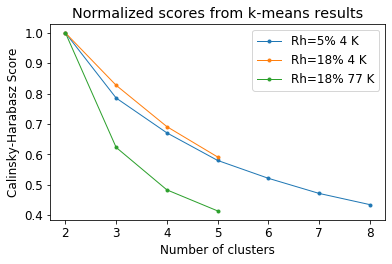

In [11]:
#Calinsky-Harabasz Scores

num_clusters_5 = [2,3,4,5,6,7,8]
Rh5_score = [3.678341e+04,2.889268e+04,2.467407e+04,2.133610e+04,1.917286e+04,1.734182e+04,1.598568e+04]
Rh5_score_norm = [Rh5_score[i]/np.max(Rh5_score) for i in range(len(Rh5_score))]

num_clusters_18_4K = [2,3,4,5]
Rh18_4K_score = [4.929720e+04,4.078790e+04,3.408128e+04,2.915653e+04]
Rh18_4K_score_norm = [Rh18_4K_score[i]/np.max(Rh18_4K_score) for i in range(len(Rh18_4K_score))]

num_clusters_18_77K = [2,3,4,5]
Rh18_77K_score = [2.178029e+03,1.924204e+03,1.697518e+03,1.517613e+03]
Rh18_77K_score_norm = [Rh18_77_inertia[i]/np.max(Rh18_77_inertia) for i in range(len(Rh18_77_inertia))]

#Score Plots
fig,(ax1) = plt.subplots()
plt.rcParams.update({'font.size': 12})
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(bottom=0.2)

ax1.plot(num_clusters_5, Rh5_score_norm, marker='.',linestyle='-', lw=1, label='Rh=5% 4 K')
ax1.plot(num_clusters_18_4K, Rh18_4K_score_norm, marker='.',linestyle='-', lw=1, label='Rh=18% 4 K')
ax1.plot(num_clusters_18_77K, Rh18_77K_score_norm, marker='.',linestyle='-', lw=1, label='Rh=18% 77 K')


ax1.set_ylabel("Calinsky-Harabasz Score")
ax1.set_xlabel("Number of clusters")
ax1.set_title('Normalized scores from k-means results')
ax1.legend()


plt.show()

In [ ]:
centroid_1_indices  = np.reshape(np.where(labels==0), -1)
centroid_2_indices  = np.reshape(np.where(labels==1), -1)
centroid_3_indices  = np.reshape(np.where(labels==2), -1)
centroid_4_indices  = np.reshape(np.where(labels==3), -1)

#Choosing 100 random spectra from cluster to plot:
rng = np.random.default_rng()
index_choice_1 = rng.choice(centroid_1_indices,100, replace=False)
index_choice_2 = rng.choice(centroid_2_indices,100, replace=False)
index_choice_3 = rng.choice(centroid_3_indices,100, replace=False)
index_choice_4 = rng.choice(centroid_4_indices,100, replace=False)

In [ ]:
#Make plot of ALL spectra within a cluster to visualize spread
energy = np.linspace(-0.8, 0.8, num=81) #evenly spaced values between +0.8 eV and -0.8 eV
energy = np.flip(energy)
img_labels = np.reshape(labels, (275,275)) #Reformating labels for map layout

#Plotting
plt.rcParams.update({'font.size': 12})
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharex=True)
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(hspace=0.01)
fig.subplots_adjust(left=0.09)
fig.subplots_adjust(right=0.99)


#Subplot 1:
for i in range(100):
    ax1.plot(energy, grid_Rh18_flattened[index_choice_2[i]], marker='',ls='-', color='gray', alpha=0.3,lw=0.5)
    
#plot the centroid spectrum
ax1.plot(energy,centroids[1], marker='',linestyle='-', color='#003C86', lw=2)
ax1.set_ylabel("DOS")
ax1.set_xlim([-0.81,0.81])
ax1.set_ylim([-0.1E-11,3.0E-11])
ax1.yaxis.set_ticks(np.arange(0.0, 3.01E-11, 0.5E-11))
#ax1.set_aspect(100000000000)


#Subplot 2:
for i in range(100):
    ax2.plot(energy, grid_Rh18_flattened[index_choice_3[i]], marker='',ls='-', color='gray', alpha=0.3, lw=0.5)
    
#plot the centroid spectrum
ax2.plot(energy,centroids[2], marker='',linestyle='-', color='#00DCB5', lw=2)
ax2.set_xlim([-0.81,0.81])
ax2.set_ylim([-0.1E-11,3.0E-11])
ax2.yaxis.set_major_locator(plt.NullLocator())
#ax2.set_aspect(100000000000)


#Subplot 3:
for i in range(100):
    ax3.plot(energy, grid_Rh18_flattened[index_choice_4[i]], marker='',ls='-', color='gray', alpha=0.3, lw=0.5)
    
#plot the centroid spectrum
ax3.plot(energy,centroids[3], marker='',linestyle='-', color='k', lw=2)
ax3.set_xlim([-0.81,0.81])
ax3.set_ylim([-0.1E-11,3.0E-11])
ax3.yaxis.set_major_locator(plt.NullLocator())
#ax3.set_aspect(100000000000)

#Subplot 4:
for i in range(100):
    ax4.plot(energy, grid_Rh18_flattened[index_choice_1[i]], marker='',ls='-', color='gray', alpha=0.3, lw=0.5)
    
#plot the centroid spectrum
ax4.plot(energy,centroids[0], marker='',linestyle='-', color='#EF0096', lw=2)
ax4.set_xlim([-0.81,0.81])
ax4.set_ylim([-0.1E-11,3.0E-11])
ax4.yaxis.set_major_locator(plt.NullLocator())
#ax4.set_aspect(100000000000)


# Set Title and x label
fig.text(0.54, 0.015, 'Bias (eV)', ha='center', va='center', fontsize=12)
fig.text(0.54, 0.93, 'Sampling spectra within a cluster', ha='center', va='center', fontsize=13)
plt.show()

In [6]:
#Trying k-means on an energy-dense line spectra.

kmeans = KMeans(n_clusters=4, init='k-means++',n_init=100, max_iter=100, random_state=0).fit(data_line)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
score = metrics.calinski_harabasz_score(data_line, labels)
print('k-means complete. BCSS / WCSS = {:0.6e}'.format(score))


k-means complete. BCSS / WCSS = 1.333144e+02


<IPython.core.display.Javascript object>


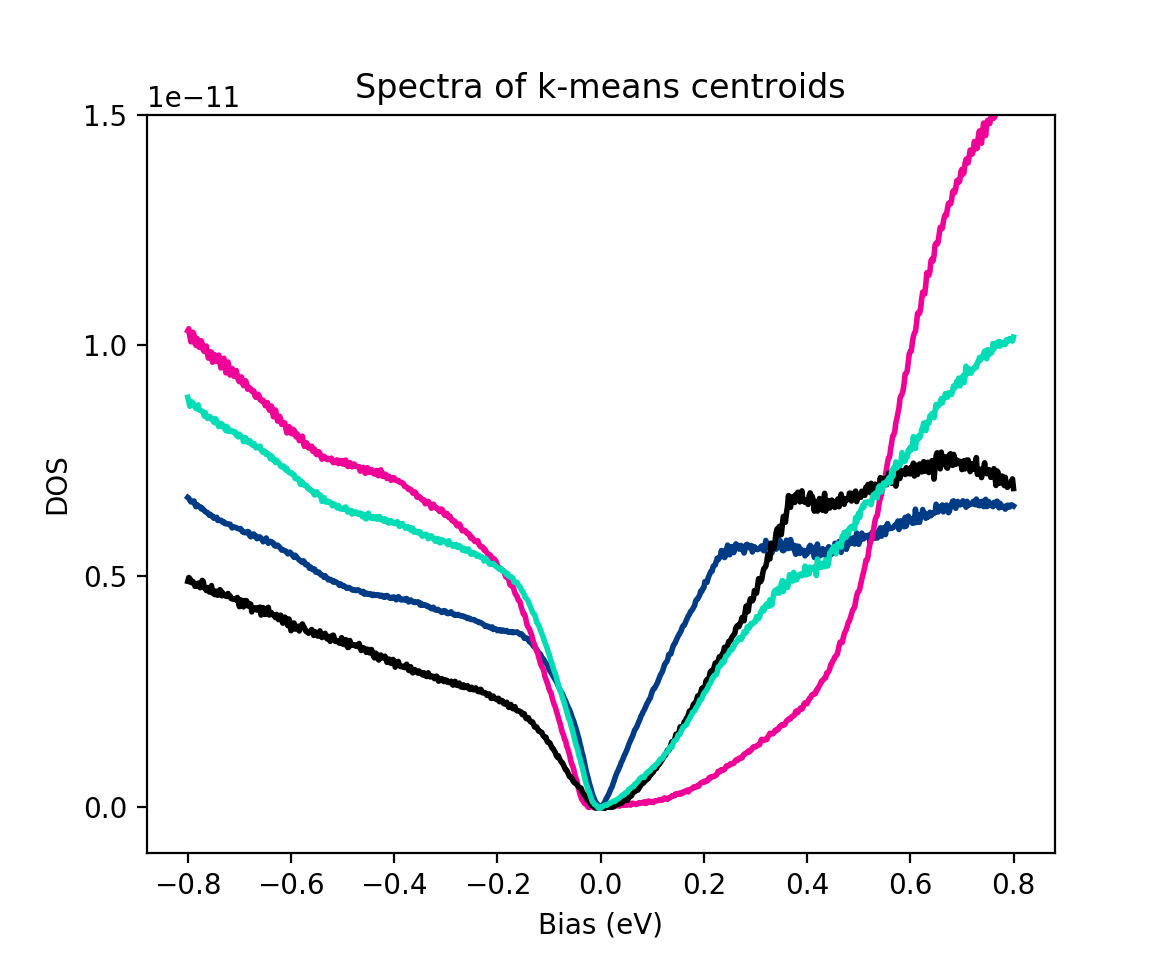

In [19]:
#Plotting
#Note on colour: '#003C86' is navy for P1
#                '#EF0096' is magenta for M
#                'k' is black for DEFFECT
#                '#00DCB5'is teal for P2

energy = np.linspace(0.8, -0.8, num=np.shape(data_line)[1])

fig,(ax1) = plt.subplots()

ax1.plot(energy,centroids[0],label="Centroid 1", marker='',linestyle='-', lw=2, color='#003C86')
ax1.plot(energy,centroids[1],label="Centroid 2", marker='',linestyle='-', lw=2, color='#EF0096')
ax1.plot(energy,centroids[2],label="Centroid 3", marker='',linestyle='-', lw=2, color='k')
ax1.plot(energy,centroids[3],label="Centroid 4", marker='',linestyle='-', lw=2, color='#00DCB5')

ax1.set_ylabel("DOS")
ax1.set_xlabel("Bias (eV)")
ax1.set_title("Spectra of k-means centroids")
#ax1.legend()
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
ax1.set_ylim(-0.1E-11, 1.50E-11)

    
plt.show()

In [18]:
#Artificially reducing resolution of line spectra to see how that changes things:

low_res_line = [[] for i in range(np.shape(data_line)[0])]
for i in range(np.shape(data_line)[0]):
    for j in range(np.shape(data_line)[1]):
        if j%4==0: #This will take us from 801 points to 201 points in eV
            low_res_line[i].append(data_line[i][j])

#Trying k-means on this less-dense line.

kmeans = KMeans(n_clusters=4, init='k-means++',n_init=100, max_iter=100, random_state=0).fit(low_res_line)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
score = metrics.calinski_harabasz_score(data_line, labels)
print('k-means complete. BCSS / WCSS = {:0.6e}'.format(score))


k-means complete. BCSS / WCSS = 1.333041e+02


<IPython.core.display.Javascript object>


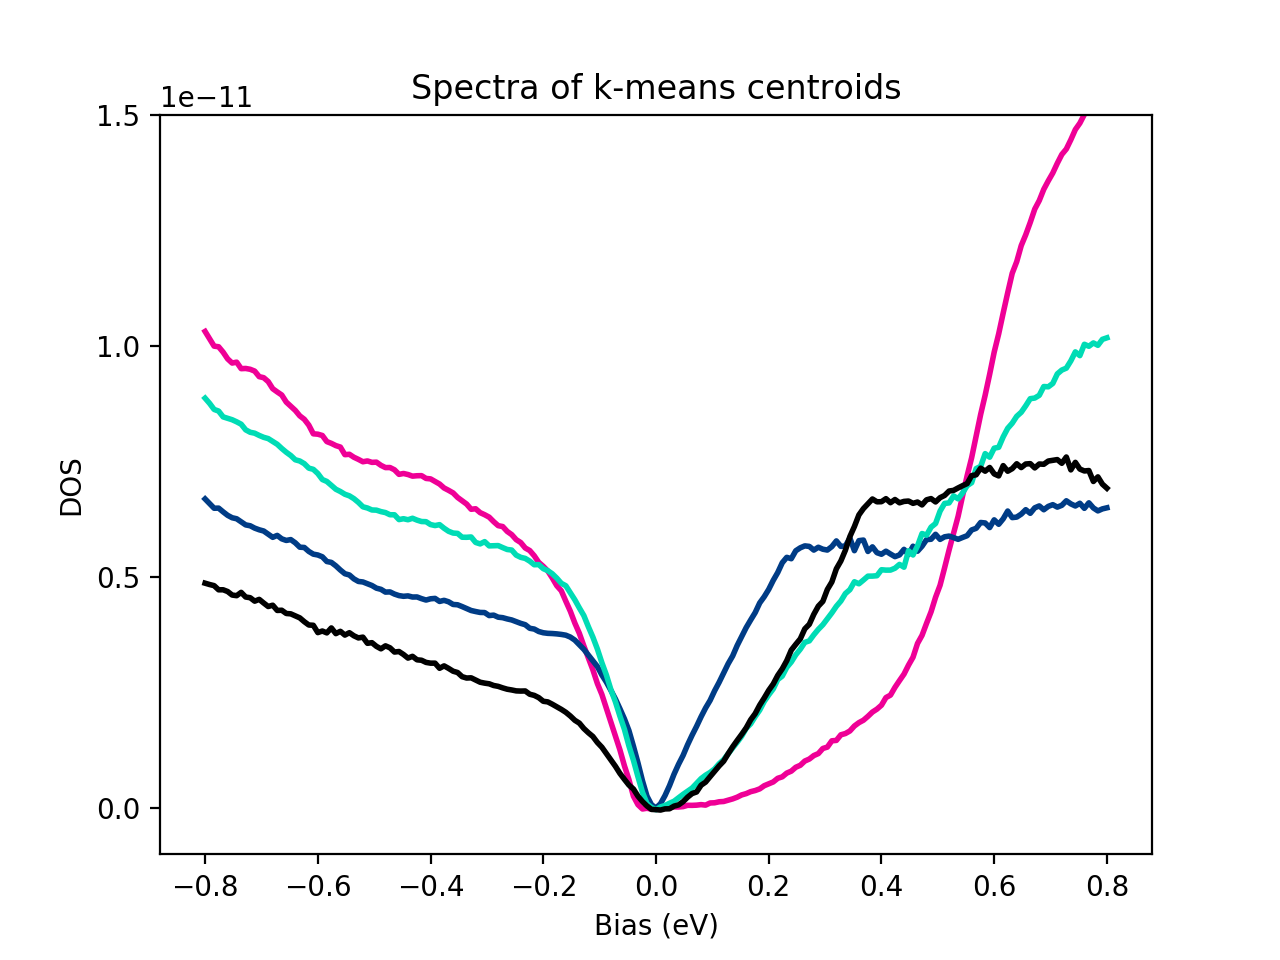

In [23]:
#Plotting
#Note on colour: '#003C86' is navy for P1
#                '#EF0096' is magenta for M
#                'k' is black for DEFFECT
#                '#00DCB5'is teal for P2

energy = np.linspace(0.8, -0.8, num=np.shape(low_res_line)[1])

fig,(ax1) = plt.subplots()

ax1.plot(energy,centroids[0],label="Centroid 1", marker='',linestyle='-', lw=2, color='#EF0096')
ax1.plot(energy,centroids[1],label="Centroid 2", marker='',linestyle='-', lw=2, color='#003C86')
ax1.plot(energy,centroids[2],label="Centroid 3", marker='',linestyle='-', lw=2, color='#00DCB5')
ax1.plot(energy,centroids[3],label="Centroid 4", marker='',linestyle='-', lw=2, color='k')

ax1.set_ylabel("DOS")
ax1.set_xlabel("Bias (eV)")
ax1.set_title("Spectra of k-means centroids")
#ax1.legend()
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
ax1.set_ylim(-0.1E-11, 1.50E-11)

    
plt.show()

# Trying something other than kMeans
Nov 8, 2021.

In [ ]:
from sklearn.cluster import DBSCAN

def myDBScan(file, eps, min_samples):
    #Data needs to be in shape (n_samples, n_features), ie: (75625, 81)
    data = np.reshape(file, (np.shape(file)[0]*np.shape(file)[1], np.shape(file)[2]))

    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=1).fit(data)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    
    return labels
    
labels = myDBScan(data_5, 5e-12, 15)
unique_labels = set(labels) #a.k.a., the set of unique identities

In [ ]:
print(unique_labels)

In [ ]:
# Plot results
def DBScan_Plot(grid, minV, maxV, labels):
    #grid = 3 dimensional data array, minV = starting voltage, maxV = final voltage, 
    #labels = labels output from kmeans, centroids = centroids output from kmeans
    
    energy = np.linspace(minV, maxV, num=np.shape(grid)[2]) #evenly spaced values between minV and maxV
    img_labels = np.reshape(labels, (np.shape(grid)[0],np.shape(grid)[1])) #Reformating labels for map layout
    #Plotting
    fig,(ax2) = plt.subplots()
    fig.subplots_adjust(hspace=0.3)
    
    
    cmap = colors.ListedColormap(['#EF0096','#003C86','#00DCB5', 'y', 'r', 'g', 'b', 'm', 'k'])
    ax2.imshow(img_labels, cmap=cmap)
    ax2.set_title("Map of cluster assignments")
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    plt.show()
    
DBScan_Plot(data_5,-0.8,0.8,labels)

In [ ]:
from sklearn.cluster import AffinityPropagation

def myAffinityPropagation(file):
    #Data needs to be in shape (n_samples, n_features), ie: (75625, 81)
    data = np.reshape(file, (np.shape(file)[0]*np.shape(file)[1], np.shape(file)[2]))

    #Compute affinity propagation
    af = AffinityPropagation(random_state=0).fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters_ = len(cluster_centers_indices)

    print("Estimated number of clusters: %d" % n_clusters_)

    return labels
    
labels = myAffinityPropagation(data_5)
unique_labels = set(labels) #a.k.a., the set of unique identities
print(unique_labels)

##### 